In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [39]:
file = 'gj1243_tess.dat.fbeye'
colnames = ('Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x')

fbeye = pd.read_table(file, delim_whitespace=True, comment='#', names=colnames)[1:] # skip the first junk row

fbeye.shape

(61, 19)

In [43]:
file = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'

tbl = Table.read(file, format='fits')

q = tbl['QUALITY'] == 0
print(sum(q))

18506


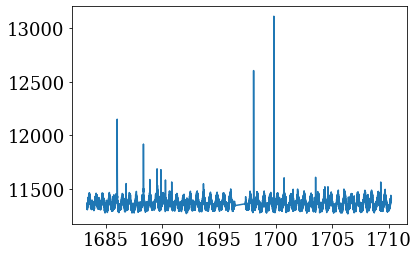

In [44]:
plt.plot(tbl['TIME'][q], tbl['PDCSAP_FLUX'][q])

In [47]:
dt = np.nanmedian(np.diff(tbl['TIME'][q]))
dt * sum(q)

25.703064112437005

In [38]:
ED = np.sort(fbeye['Equiv_Dur'].values)[::-1]

ED # do I need to recalc these? go back and check...

array([58.05338995, 56.6145924 , 52.02351168, 39.9712496 , 30.3439015 ,
       15.95454986, 15.7362914 , 14.10914304, 13.70797719, 13.35393683,
       12.8700199 , 12.06294716, 11.1586208 , 10.99196171,  8.42411534,
        7.61845708,  7.48853336,  5.47222352,  5.39707749,  5.24104857,
        5.19507334,  4.75508075,  4.60973394,  4.48873646,  4.37006469,
        4.11236044,  4.05682655,  3.60860824,  3.51136765,  3.21290313,
        2.73275488,  2.53941741,  2.46178904,  2.45628996,  2.33313785,
        2.29797376,  2.29733378,  2.12601905,  2.10578122,  1.96789693,
        1.91427316,  1.91060859,  1.88735504,  1.85798727,  1.78955554,
        1.78893203,  1.76713209,  1.71820928,  1.6627849 ,  1.50543464,
        1.38678801,  1.35302011,  1.32302601,  1.27392242,  1.19653063,
        1.07740835,  1.03941585,  1.02139691,  0.96712136,  0.80948728,
        0.7096735 ])

In [75]:
LUMIN = 30.5 # this is a made-up number. Replace with TRUTH from spectrum+filter convolution!

TOTDUR = dt * sum(q) # days

ffd_x = np.log10(ED) + LUMIN
ffd_y = np.log10(np.arange(1, len(ED)+1) / TOTDUR)

Text(0.5, 1.0, 'GJ 1243 - TESS Sector 14')

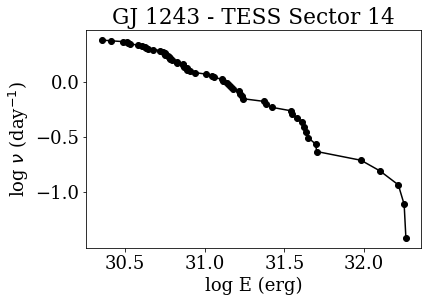

In [76]:
plt.plot(ffd_x, ffd_y, '-o', color='k')

plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243 - TESS Sector 14')

In [82]:
E_POINT = 30.665290     #    ;-- from SLH paper

kep_lc = pd.read_table('GJ1243-Flares/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
TOTDUR_KEP = len(kep_lc) * 58.0 / 60./60./24.

kep_flares_file = 'GJ1243-Flares/data/gj1243_master_flares.tbl'
kflare = pd.read_table(kep_flares_file, delim_whitespace=True, comment='#',
                       names=('fstart', 'fstop', 'tstart', 'tstop', 'tpeak', 'trise', 'tdecay', 'fpeak', 
                              'ed', 'edrise', 'eddecay', 'cplx_flg', 'ppl1', 'ppl2','npts'))

In [83]:
TOTDUR_KEP

291.4526851851852

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'GJ 1243')

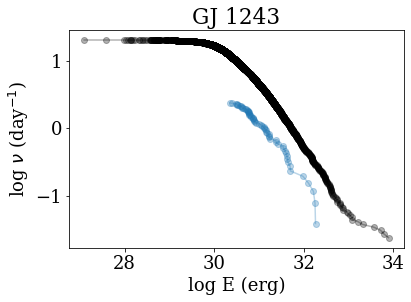

In [87]:
ffd_xk = np.log10(np.sort(kflare['ed'])[::-1]) + E_POINT
ffd_yk = np.log10(np.arange(1, len(ffd_xk)+1) / TOTDUR_KEP)

plt.plot(ffd_xk, ffd_yk, '-o', color='k', alpha=0.3)
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.3)

plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')